# GANomaly
- 2020.08.17 : gen 4 / lr 1e-5

# 개발일지
- 2020.08.15 : 분율 추출 구현 / 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티타늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100  # z벡터의 잠재공간(latent space)의 크기
workers = 4    # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
#data_root = "../../dataset/train"
Ti64_aug_data_root = "../../dataset/aug_train/aug_Ti64"

data_set = dataset.ImageFolder(root = Ti64_aug_data_root, # data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 1020
device : cuda:0


# MODEL

In [4]:
# GANomaly : Generative Adversarial Networks Model using Decoder with AutoEncoder

# === Decoder 모델 ===
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def DC_conv_block(in_features, out_features):
            block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
            ]
            return block
        
        def DC_deconv_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.DC_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *DC_deconv_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *DC_conv_block(img_size*8, img_size*8),
            # ------ state size is 512x4x4 ------   
            *DC_deconv_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *DC_conv_block(img_size*4, img_size*4),
            # ------ state size is 256x8x8 ------ 
            *DC_deconv_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *DC_conv_block(img_size*2, img_size*2),
            # ------ state size is 128x16x16 ------ 
            *DC_deconv_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.DC_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1, 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.DC_gen_distribution(input)
        fake_img = self.DC_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *D_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *D_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *D_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *D_block(img_size*8, img_size*8, MP=True),
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature 


# === Encoder Model ===
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        def EC_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 ==============
        self.EC_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *EC_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *EC_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *EC_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *EC_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *EC_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *EC_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *EC_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *EC_block(img_size*8, img_size*8, MP=True),
        )
        
        # =============== Encoder Training layer ===============
        self.EC_validate = nn.Sequential(
            # -------state is 512 x 4 x 4-------
            nn.Conv2d(img_size*8, latent_size, 4, 1, 0, bias=False),
            nn.Tanh()
            # -------state is 100 x 97 x 97-------
        )
        
    def forward(self, input):
        feature = self.EC_extract_feature(input)
        validity = self.EC_validate(feature)
        
        return validity

# Loss & Optim

In [5]:
# DC and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,DC,EC 네트워크 모델 객체 선언
D = Discriminator().to(device)
DC = Decoder().to(device)
EC = Encoder().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
DC.apply(weights_init)
EC.apply(weights_init)

# Binary cross entropy loss and optimizer
DCGAN_criterion = nn.BCELoss()
AE_criterion = nn.MSELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 DC로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 DC에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
DC_optimizer = torch.optim.Adam(DC.parameters(), lr = learning_rate, betas=(0.5,0.999))
EC_optimizer = torch.optim.Adam(EC.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(DC)
#print(EC)

def reset_grad():
    D_optimizer.zero_grad()
    DC_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
DC_losses = []
D_losses = []
iters = 0

def train_DCGAN(epoch, learning_DC_per_D = 4):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train D
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = DCGAN_criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = DC(z)
        fake_classification, _ = D(fake_img) # output = D(DC(z))
        fake_loss = DCGAN_criterion(fake_classification, fake_labels) # D(DC(z))=0일 때의 loss
        fake_score = fake_classification
        D_DC_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(DC(z))=0이어야 D가 최적

        
        # Train DC
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_DC_per_D):
            fake_img = DC(z)
            fake_classification,_ = D(fake_img)  # output : D(DC(z))
            D_DC_z2 = fake_classification.mean().item()
            DC_loss = DCGAN_criterion(fake_classification, real_labels) # D(DC(z))=1일 때의 loss=log(D(DC(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            DC_loss.backward()
            DC_optimizer.step() # D(DC(z))=1 이어야 DC가 최적
            # ==> D(DC(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / DC_loss : %.4f\n- D(x):%.4f / D(DC(z1)) : %.4f / D(DC(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     DC_loss.item(),D_x,D_DC_z1,D_DC_z2))
        
        # Save Losses for plotting later
        DC_losses.append(DC_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [7]:
for epoch in range(epochs):
    train_DCGAN(epoch, learning_DC_per_D = 4)

/home/piai/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/15]
- D_loss : 1.3770 / DC_loss : 0.6940
- D(x):0.4974 / D(DC(z1)) : 0.4925 / D(DC(z2)) : 0.4996
[1/100][1/15]
- D_loss : 1.3668 / DC_loss : 0.7060
- D(x):0.4976 / D(DC(z1)) : 0.4876 / D(DC(z2)) : 0.4937
[1/100][2/15]
- D_loss : 1.3578 / DC_loss : 0.7175
- D(x):0.4966 / D(DC(z1)) : 0.4819 / D(DC(z2)) : 0.4880
[1/100][3/15]
- D_loss : 1.3470 / DC_loss : 0.7262
- D(x):0.4975 / D(DC(z1)) : 0.4771 / D(DC(z2)) : 0.4838
[1/100][4/15]
- D_loss : 1.3412 / DC_loss : 0.7352
- D(x):0.4962 / D(DC(z1)) : 0.4727 / D(DC(z2)) : 0.4795
[1/100][5/15]
- D_loss : 1.3271 / DC_loss : 0.7453
- D(x):0.4985 / D(DC(z1)) : 0.4677 / D(DC(z2)) : 0.4746
[1/100][6/15]
- D_loss : 1.3224 / DC_loss : 0.7546
- D(x):0.4966 / D(DC(z1)) : 0.4631 / D(DC(z2)) : 0.4703
[1/100][7/15]
- D_loss : 1.3121 / DC_loss : 0.7644
- D(x):0.4980 / D(DC(z1)) : 0.4590 / D(DC(z2)) : 0.4657
[1/100][8/15]
- D_loss : 1.3022 / DC_loss : 0.7734
- D(x):0.4988 / D(DC(z1)) : 0.4545 / D(DC(z2)) : 0.4615
[1/100][9/15]
- D_loss : 1.2936 / DC_

[6/100][2/15]
- D_loss : 1.1723 / DC_loss : 0.8820
- D(x):0.5336 / D(DC(z1)) : 0.4166 / D(DC(z2)) : 0.4173
[6/100][3/15]
- D_loss : 1.1527 / DC_loss : 0.8901
- D(x):0.5403 / D(DC(z1)) : 0.4125 / D(DC(z2)) : 0.4137
[6/100][4/15]
- D_loss : 1.1499 / DC_loss : 0.9001
- D(x):0.5374 / D(DC(z1)) : 0.4076 / D(DC(z2)) : 0.4097
[6/100][5/15]
- D_loss : 1.1426 / DC_loss : 0.9019
- D(x):0.5408 / D(DC(z1)) : 0.4073 / D(DC(z2)) : 0.4094
[6/100][6/15]
- D_loss : 1.1174 / DC_loss : 0.9026
- D(x):0.5539 / D(DC(z1)) : 0.4062 / D(DC(z2)) : 0.4093
[6/100][7/15]
- D_loss : 1.1144 / DC_loss : 0.9202
- D(x):0.5484 / D(DC(z1)) : 0.3985 / D(DC(z2)) : 0.4018
[6/100][8/15]
- D_loss : 1.1241 / DC_loss : 0.9159
- D(x):0.5453 / D(DC(z1)) : 0.4005 / D(DC(z2)) : 0.4044
[6/100][9/15]
- D_loss : 1.1121 / DC_loss : 0.9064
- D(x):0.5564 / D(DC(z1)) : 0.4048 / D(DC(z2)) : 0.4101
[6/100][10/15]
- D_loss : 1.1294 / DC_loss : 0.9069
- D(x):0.5458 / D(DC(z1)) : 0.4037 / D(DC(z2)) : 0.4092
[6/100][11/15]
- D_loss : 1.1328 / D

[11/100][4/15]
- D_loss : 1.0023 / DC_loss : 1.0402
- D(x):0.5767 / D(DC(z1)) : 0.3606 / D(DC(z2)) : 0.3539
[11/100][5/15]
- D_loss : 0.9821 / DC_loss : 1.0544
- D(x):0.5830 / D(DC(z1)) : 0.3541 / D(DC(z2)) : 0.3490
[11/100][6/15]
- D_loss : 1.0292 / DC_loss : 1.0586
- D(x):0.5516 / D(DC(z1)) : 0.3503 / D(DC(z2)) : 0.3473
[11/100][7/15]
- D_loss : 0.9828 / DC_loss : 1.0514
- D(x):0.5802 / D(DC(z1)) : 0.3522 / D(DC(z2)) : 0.3498
[11/100][8/15]
- D_loss : 0.9912 / DC_loss : 1.0589
- D(x):0.5723 / D(DC(z1)) : 0.3481 / D(DC(z2)) : 0.3471
[11/100][9/15]
- D_loss : 0.9633 / DC_loss : 1.0490
- D(x):0.5903 / D(DC(z1)) : 0.3512 / D(DC(z2)) : 0.3505
[11/100][10/15]
- D_loss : 0.9861 / DC_loss : 1.0466
- D(x):0.5789 / D(DC(z1)) : 0.3522 / D(DC(z2)) : 0.3513
[11/100][11/15]
- D_loss : 0.9501 / DC_loss : 1.0484
- D(x):0.6007 / D(DC(z1)) : 0.3526 / D(DC(z2)) : 0.3507
[11/100][12/15]
- D_loss : 0.9546 / DC_loss : 1.0465
- D(x):0.5989 / D(DC(z1)) : 0.3542 / D(DC(z2)) : 0.3513
[11/100][13/15]
- D_loss 

[16/100][5/15]
- D_loss : 0.6341 / DC_loss : 1.3806
- D(x):0.7213 / D(DC(z1)) : 0.2616 / D(DC(z2)) : 0.2516
[16/100][6/15]
- D_loss : 0.6732 / DC_loss : 1.4011
- D(x):0.6899 / D(DC(z1)) : 0.2561 / D(DC(z2)) : 0.2465
[16/100][7/15]
- D_loss : 0.6031 / DC_loss : 1.4286
- D(x):0.7337 / D(DC(z1)) : 0.2504 / D(DC(z2)) : 0.2398
[16/100][8/15]
- D_loss : 0.6197 / DC_loss : 1.4530
- D(x):0.7160 / D(DC(z1)) : 0.2433 / D(DC(z2)) : 0.2341
[16/100][9/15]
- D_loss : 0.6135 / DC_loss : 1.4702
- D(x):0.7138 / D(DC(z1)) : 0.2375 / D(DC(z2)) : 0.2300
[16/100][10/15]
- D_loss : 0.6085 / DC_loss : 1.4836
- D(x):0.7134 / D(DC(z1)) : 0.2332 / D(DC(z2)) : 0.2270
[16/100][11/15]
- D_loss : 0.5725 / DC_loss : 1.5004
- D(x):0.7347 / D(DC(z1)) : 0.2291 / D(DC(z2)) : 0.2233
[16/100][12/15]
- D_loss : 0.5717 / DC_loss : 1.5074
- D(x):0.7332 / D(DC(z1)) : 0.2267 / D(DC(z2)) : 0.2217
[16/100][13/15]
- D_loss : 0.5309 / DC_loss : 1.5177
- D(x):0.7607 / D(DC(z1)) : 0.2242 / D(DC(z2)) : 0.2195
[16/100][14/15]
- D_loss

[21/100][6/15]
- D_loss : 0.4611 / DC_loss : 1.6605
- D(x):0.7870 / D(DC(z1)) : 0.1937 / D(DC(z2)) : 0.1901
[21/100][7/15]
- D_loss : 0.4191 / DC_loss : 1.6637
- D(x):0.8172 / D(DC(z1)) : 0.1928 / D(DC(z2)) : 0.1895
[21/100][8/15]
- D_loss : 0.4504 / DC_loss : 1.6610
- D(x):0.7925 / D(DC(z1)) : 0.1922 / D(DC(z2)) : 0.1900
[21/100][9/15]
- D_loss : 0.4288 / DC_loss : 1.6527
- D(x):0.8102 / D(DC(z1)) : 0.1932 / D(DC(z2)) : 0.1916
[21/100][10/15]
- D_loss : 0.4145 / DC_loss : 1.6464
- D(x):0.8226 / D(DC(z1)) : 0.1949 / D(DC(z2)) : 0.1928
[21/100][11/15]
- D_loss : 0.4141 / DC_loss : 1.6437
- D(x):0.8247 / D(DC(z1)) : 0.1965 / D(DC(z2)) : 0.1933
[21/100][12/15]
- D_loss : 0.4096 / DC_loss : 1.6479
- D(x):0.8283 / D(DC(z1)) : 0.1965 / D(DC(z2)) : 0.1925
[21/100][13/15]
- D_loss : 0.4506 / DC_loss : 1.6527
- D(x):0.7951 / D(DC(z1)) : 0.1955 / D(DC(z2)) : 0.1916
[21/100][14/15]
- D_loss : 0.4139 / DC_loss : 1.6609
- D(x):0.8230 / D(DC(z1)) : 0.1947 / D(DC(z2)) : 0.1900
[22/100][0/15]
- D_loss

[26/100][7/15]
- D_loss : 0.3527 / DC_loss : 1.5865
- D(x):0.8759 / D(DC(z1)) : 0.1968 / D(DC(z2)) : 0.2050
[26/100][8/15]
- D_loss : 0.4255 / DC_loss : 1.6278
- D(x):0.8448 / D(DC(z1)) : 0.2244 / D(DC(z2)) : 0.1968
[26/100][9/15]
- D_loss : 0.4071 / DC_loss : 1.7707
- D(x):0.8431 / D(DC(z1)) : 0.2085 / D(DC(z2)) : 0.1707
[26/100][10/15]
- D_loss : 0.3750 / DC_loss : 1.8913
- D(x):0.8369 / D(DC(z1)) : 0.1765 / D(DC(z2)) : 0.1513
[26/100][11/15]
- D_loss : 0.3294 / DC_loss : 1.9654
- D(x):0.8519 / D(DC(z1)) : 0.1545 / D(DC(z2)) : 0.1404
[26/100][12/15]
- D_loss : 0.3684 / DC_loss : 1.9941
- D(x):0.8114 / D(DC(z1)) : 0.1433 / D(DC(z2)) : 0.1363
[26/100][13/15]
- D_loss : 0.2980 / DC_loss : 2.0178
- D(x):0.8630 / D(DC(z1)) : 0.1387 / D(DC(z2)) : 0.1332
[26/100][14/15]
- D_loss : 0.3147 / DC_loss : 2.0346
- D(x):0.8461 / D(DC(z1)) : 0.1352 / D(DC(z2)) : 0.1310
[27/100][0/15]
- D_loss : 0.2838 / DC_loss : 2.0540
- D(x):0.8697 / D(DC(z1)) : 0.1330 / D(DC(z2)) : 0.1285
[27/100][1/15]
- D_loss

[31/100][8/15]
- D_loss : 0.2477 / DC_loss : 1.9307
- D(x):0.9186 / D(DC(z1)) : 0.1499 / D(DC(z2)) : 0.1451
[31/100][9/15]
- D_loss : 0.2703 / DC_loss : 1.9344
- D(x):0.8976 / D(DC(z1)) : 0.1486 / D(DC(z2)) : 0.1445
[31/100][10/15]
- D_loss : 0.2766 / DC_loss : 1.9366
- D(x):0.8915 / D(DC(z1)) : 0.1482 / D(DC(z2)) : 0.1442
[31/100][11/15]
- D_loss : 0.2593 / DC_loss : 1.9558
- D(x):0.9062 / D(DC(z1)) : 0.1478 / D(DC(z2)) : 0.1415
[31/100][12/15]
- D_loss : 0.2588 / DC_loss : 1.9808
- D(x):0.9034 / D(DC(z1)) : 0.1449 / D(DC(z2)) : 0.1380
[31/100][13/15]
- D_loss : 0.2584 / DC_loss : 2.0114
- D(x):0.9003 / D(DC(z1)) : 0.1411 / D(DC(z2)) : 0.1338
[31/100][14/15]
- D_loss : 0.2540 / DC_loss : 2.0507
- D(x):0.8997 / D(DC(z1)) : 0.1364 / D(DC(z2)) : 0.1286
[32/100][0/15]
- D_loss : 0.2443 / DC_loss : 2.0894
- D(x):0.9023 / D(DC(z1)) : 0.1311 / D(DC(z2)) : 0.1238
[32/100][1/15]
- D_loss : 0.2453 / DC_loss : 2.1213
- D(x):0.8964 / D(DC(z1)) : 0.1259 / D(DC(z2)) : 0.1199
[32/100][2/15]
- D_loss

[36/100][9/15]
- D_loss : 0.1596 / DC_loss : 2.6068
- D(x):0.9222 / D(DC(z1)) : 0.0752 / D(DC(z2)) : 0.0738
[36/100][10/15]
- D_loss : 0.1588 / DC_loss : 2.6168
- D(x):0.9221 / D(DC(z1)) : 0.0743 / D(DC(z2)) : 0.0730
[36/100][11/15]
- D_loss : 0.1610 / DC_loss : 2.6283
- D(x):0.9197 / D(DC(z1)) : 0.0736 / D(DC(z2)) : 0.0722
[36/100][12/15]
- D_loss : 0.1551 / DC_loss : 2.6377
- D(x):0.9239 / D(DC(z1)) : 0.0726 / D(DC(z2)) : 0.0715
[36/100][13/15]
- D_loss : 0.1567 / DC_loss : 2.6384
- D(x):0.9217 / D(DC(z1)) : 0.0720 / D(DC(z2)) : 0.0715
[36/100][14/15]
- D_loss : 0.1543 / DC_loss : 2.6380
- D(x):0.9238 / D(DC(z1)) : 0.0719 / D(DC(z2)) : 0.0715
[37/100][0/15]
- D_loss : 0.1499 / DC_loss : 2.6366
- D(x):0.9280 / D(DC(z1)) : 0.0719 / D(DC(z2)) : 0.0716
[37/100][1/15]
- D_loss : 0.1664 / DC_loss : 2.6240
- D(x):0.9132 / D(DC(z1)) : 0.0721 / D(DC(z2)) : 0.0725
[37/100][2/15]
- D_loss : 0.1636 / DC_loss : 2.6028
- D(x):0.9166 / D(DC(z1)) : 0.0731 / D(DC(z2)) : 0.0741
[37/100][3/15]
- D_loss

[41/100][10/15]
- D_loss : 0.1451 / DC_loss : 2.6587
- D(x):0.9355 / D(DC(z1)) : 0.0751 / D(DC(z2)) : 0.0701
[41/100][11/15]
- D_loss : 0.1490 / DC_loss : 2.6678
- D(x):0.9277 / D(DC(z1)) : 0.0707 / D(DC(z2)) : 0.0694
[41/100][12/15]
- D_loss : 0.1474 / DC_loss : 2.6655
- D(x):0.9287 / D(DC(z1)) : 0.0701 / D(DC(z2)) : 0.0696
[41/100][13/15]
- D_loss : 0.1436 / DC_loss : 2.6717
- D(x):0.9322 / D(DC(z1)) : 0.0702 / D(DC(z2)) : 0.0692
[41/100][14/15]
- D_loss : 0.1357 / DC_loss : 2.6717
- D(x):0.9388 / D(DC(z1)) : 0.0697 / D(DC(z2)) : 0.0691
[42/100][0/15]
- D_loss : 0.1439 / DC_loss : 2.6726
- D(x):0.9313 / D(DC(z1)) : 0.0698 / D(DC(z2)) : 0.0691
[42/100][1/15]
- D_loss : 0.1512 / DC_loss : 2.6583
- D(x):0.9245 / D(DC(z1)) : 0.0696 / D(DC(z2)) : 0.0701
[42/100][2/15]
- D_loss : 0.1334 / DC_loss : 2.6666
- D(x):0.9418 / D(DC(z1)) : 0.0706 / D(DC(z2)) : 0.0695
[42/100][3/15]
- D_loss : 0.1359 / DC_loss : 2.6848
- D(x):0.9389 / D(DC(z1)) : 0.0700 / D(DC(z2)) : 0.0683
[42/100][4/15]
- D_loss

[46/100][11/15]
- D_loss : 0.2002 / DC_loss : 2.4534
- D(x):0.8952 / D(DC(z1)) : 0.0843 / D(DC(z2)) : 0.0860
[46/100][12/15]
- D_loss : 0.1975 / DC_loss : 2.3489
- D(x):0.9027 / D(DC(z1)) : 0.0897 / D(DC(z2)) : 0.0955
[46/100][13/15]
- D_loss : 0.1982 / DC_loss : 2.3041
- D(x):0.9129 / D(DC(z1)) : 0.1009 / D(DC(z2)) : 0.0999
[46/100][14/15]
- D_loss : 0.2192 / DC_loss : 2.2617
- D(x):0.9006 / D(DC(z1)) : 0.1065 / D(DC(z2)) : 0.1042
[47/100][0/15]
- D_loss : 0.2325 / DC_loss : 2.1685
- D(x):0.8935 / D(DC(z1)) : 0.1121 / D(DC(z2)) : 0.1144
[47/100][1/15]
- D_loss : 0.1936 / DC_loss : 2.3010
- D(x):0.9414 / D(DC(z1)) : 0.1245 / D(DC(z2)) : 0.1002
[47/100][2/15]
- D_loss : 0.2923 / DC_loss : 1.9558
- D(x):0.8441 / D(DC(z1)) : 0.1087 / D(DC(z2)) : 0.1415
[47/100][3/15]
- D_loss : 0.4019 / DC_loss : 1.3601
- D(x):0.8072 / D(DC(z1)) : 0.1593 / D(DC(z2)) : 0.2567
[47/100][4/15]
- D_loss : 0.4303 / DC_loss : 2.2999
- D(x):0.9182 / D(DC(z1)) : 0.2914 / D(DC(z2)) : 0.1003
[47/100][5/15]
- D_loss 

[51/100][12/15]
- D_loss : 0.1901 / DC_loss : 2.1989
- D(x):0.9246 / D(DC(z1)) : 0.1046 / D(DC(z2)) : 0.1109
[51/100][13/15]
- D_loss : 0.1978 / DC_loss : 2.1493
- D(x):0.9309 / D(DC(z1)) : 0.1172 / D(DC(z2)) : 0.1166
[51/100][14/15]
- D_loss : 0.2081 / DC_loss : 2.1707
- D(x):0.9273 / D(DC(z1)) : 0.1228 / D(DC(z2)) : 0.1141
[52/100][0/15]
- D_loss : 0.1835 / DC_loss : 2.1929
- D(x):0.9465 / D(DC(z1)) : 0.1203 / D(DC(z2)) : 0.1116
[52/100][1/15]
- D_loss : 0.1974 / DC_loss : 2.2558
- D(x):0.9300 / D(DC(z1)) : 0.1168 / D(DC(z2)) : 0.1048
[52/100][2/15]
- D_loss : 0.1758 / DC_loss : 2.3259
- D(x):0.9406 / D(DC(z1)) : 0.1079 / D(DC(z2)) : 0.0977
[52/100][3/15]
- D_loss : 0.1883 / DC_loss : 2.3681
- D(x):0.9217 / D(DC(z1)) : 0.1005 / D(DC(z2)) : 0.0937
[52/100][4/15]
- D_loss : 0.1652 / DC_loss : 2.3941
- D(x):0.9375 / D(DC(z1)) : 0.0953 / D(DC(z2)) : 0.0913
[52/100][5/15]
- D_loss : 0.1675 / DC_loss : 2.4129
- D(x):0.9323 / D(DC(z1)) : 0.0923 / D(DC(z2)) : 0.0896
[52/100][6/15]
- D_loss :

[56/100][13/15]
- D_loss : 0.1101 / DC_loss : 2.9283
- D(x):0.9472 / D(DC(z1)) : 0.0541 / D(DC(z2)) : 0.0535
[56/100][14/15]
- D_loss : 0.0993 / DC_loss : 2.9331
- D(x):0.9571 / D(DC(z1)) : 0.0538 / D(DC(z2)) : 0.0532
[57/100][0/15]
- D_loss : 0.0971 / DC_loss : 2.9431
- D(x):0.9589 / D(DC(z1)) : 0.0535 / D(DC(z2)) : 0.0527
[57/100][1/15]
- D_loss : 0.0994 / DC_loss : 2.9472
- D(x):0.9564 / D(DC(z1)) : 0.0531 / D(DC(z2)) : 0.0525
[57/100][2/15]
- D_loss : 0.0992 / DC_loss : 2.9541
- D(x):0.9562 / D(DC(z1)) : 0.0528 / D(DC(z2)) : 0.0521
[57/100][3/15]
- D_loss : 0.0959 / DC_loss : 2.9592
- D(x):0.9589 / D(DC(z1)) : 0.0524 / D(DC(z2)) : 0.0519
[57/100][4/15]
- D_loss : 0.0913 / DC_loss : 2.9680
- D(x):0.9631 / D(DC(z1)) : 0.0522 / D(DC(z2)) : 0.0514
[57/100][5/15]
- D_loss : 0.0943 / DC_loss : 2.9766
- D(x):0.9597 / D(DC(z1)) : 0.0517 / D(DC(z2)) : 0.0510
[57/100][6/15]
- D_loss : 0.0937 / DC_loss : 2.9848
- D(x):0.9598 / D(DC(z1)) : 0.0512 / D(DC(z2)) : 0.0506
[57/100][7/15]
- D_loss : 

[61/100][14/15]
- D_loss : 0.0784 / DC_loss : 3.2660
- D(x):0.9609 / D(DC(z1)) : 0.0377 / D(DC(z2)) : 0.0382
[62/100][0/15]
- D_loss : 0.0707 / DC_loss : 3.2416
- D(x):0.9693 / D(DC(z1)) : 0.0387 / D(DC(z2)) : 0.0391
[62/100][1/15]
- D_loss : 0.0721 / DC_loss : 3.2095
- D(x):0.9690 / D(DC(z1)) : 0.0397 / D(DC(z2)) : 0.0404
[62/100][2/15]
- D_loss : 0.0758 / DC_loss : 3.1629
- D(x):0.9671 / D(DC(z1)) : 0.0414 / D(DC(z2)) : 0.0423
[62/100][3/15]
- D_loss : 0.0768 / DC_loss : 3.1195
- D(x):0.9682 / D(DC(z1)) : 0.0435 / D(DC(z2)) : 0.0442
[62/100][4/15]
- D_loss : 0.0775 / DC_loss : 3.0772
- D(x):0.9698 / D(DC(z1)) : 0.0457 / D(DC(z2)) : 0.0461
[62/100][5/15]
- D_loss : 0.0821 / DC_loss : 3.0572
- D(x):0.9671 / D(DC(z1)) : 0.0475 / D(DC(z2)) : 0.0470
[62/100][6/15]
- D_loss : 0.0825 / DC_loss : 3.0375
- D(x):0.9683 / D(DC(z1)) : 0.0489 / D(DC(z2)) : 0.0480
[62/100][7/15]
- D_loss : 0.0876 / DC_loss : 3.0511
- D(x):0.9643 / D(DC(z1)) : 0.0498 / D(DC(z2)) : 0.0473
[62/100][8/15]
- D_loss : 0

[67/100][0/15]
- D_loss : 0.7897 / DC_loss : 1.0973
- D(x):0.7384 / D(DC(z1)) : 0.3749 / D(DC(z2)) : 0.3338
[67/100][1/15]
- D_loss : 0.8646 / DC_loss : 1.0200
- D(x):0.6999 / D(DC(z1)) : 0.3868 / D(DC(z2)) : 0.3606
[67/100][2/15]
- D_loss : 1.0240 / DC_loss : 0.9638
- D(x):0.6338 / D(DC(z1)) : 0.4230 / D(DC(z2)) : 0.3815
[67/100][3/15]
- D_loss : 1.0121 / DC_loss : 1.1799
- D(x):0.6661 / D(DC(z1)) : 0.4451 / D(DC(z2)) : 0.3073
[67/100][4/15]
- D_loss : 0.8521 / DC_loss : 1.5507
- D(x):0.6749 / D(DC(z1)) : 0.3579 / D(DC(z2)) : 0.2121
[67/100][5/15]
- D_loss : 0.6206 / DC_loss : 1.8329
- D(x):0.7265 / D(DC(z1)) : 0.2460 / D(DC(z2)) : 0.1600
[67/100][6/15]
- D_loss : 0.5130 / DC_loss : 1.8315
- D(x):0.7456 / D(DC(z1)) : 0.1845 / D(DC(z2)) : 0.1602
[67/100][7/15]
- D_loss : 0.4602 / DC_loss : 1.6858
- D(x):0.7830 / D(DC(z1)) : 0.1900 / D(DC(z2)) : 0.1853
[67/100][8/15]
- D_loss : 0.5486 / DC_loss : 1.5203
- D(x):0.7521 / D(DC(z1)) : 0.2256 / D(DC(z2)) : 0.2186
[67/100][9/15]
- D_loss : 0.

[72/100][1/15]
- D_loss : 0.3896 / DC_loss : 2.0744
- D(x):0.7853 / D(DC(z1)) : 0.1316 / D(DC(z2)) : 0.1256
[72/100][2/15]
- D_loss : 0.3476 / DC_loss : 2.0700
- D(x):0.8297 / D(DC(z1)) : 0.1357 / D(DC(z2)) : 0.1262
[72/100][3/15]
- D_loss : 0.4075 / DC_loss : 2.0009
- D(x):0.7848 / D(DC(z1)) : 0.1352 / D(DC(z2)) : 0.1352
[72/100][4/15]
- D_loss : 0.3707 / DC_loss : 2.0101
- D(x):0.8160 / D(DC(z1)) : 0.1443 / D(DC(z2)) : 0.1340
[72/100][5/15]
- D_loss : 0.3279 / DC_loss : 2.1201
- D(x):0.8458 / D(DC(z1)) : 0.1426 / D(DC(z2)) : 0.1200
[72/100][6/15]
- D_loss : 0.2966 / DC_loss : 2.2080
- D(x):0.8545 / D(DC(z1)) : 0.1273 / D(DC(z2)) : 0.1099
[72/100][7/15]
- D_loss : 0.4205 / DC_loss : 1.8709
- D(x):0.7520 / D(DC(z1)) : 0.1163 / D(DC(z2)) : 0.1540
[72/100][8/15]
- D_loss : 0.2757 / DC_loss : 2.0155
- D(x):0.9108 / D(DC(z1)) : 0.1655 / D(DC(z2)) : 0.1333
[72/100][9/15]
- D_loss : 0.2667 / DC_loss : 2.1941
- D(x):0.8956 / D(DC(z1)) : 0.1432 / D(DC(z2)) : 0.1115
[72/100][10/15]
- D_loss : 0

[77/100][2/15]
- D_loss : 0.1941 / DC_loss : 2.5679
- D(x):0.9069 / D(DC(z1)) : 0.0879 / D(DC(z2)) : 0.0767
[77/100][3/15]
- D_loss : 0.2217 / DC_loss : 2.5537
- D(x):0.8817 / D(DC(z1)) : 0.0804 / D(DC(z2)) : 0.0778
[77/100][4/15]
- D_loss : 0.1676 / DC_loss : 2.5807
- D(x):0.9221 / D(DC(z1)) : 0.0816 / D(DC(z2)) : 0.0757
[77/100][5/15]
- D_loss : 0.1507 / DC_loss : 2.6184
- D(x):0.9351 / D(DC(z1)) : 0.0797 / D(DC(z2)) : 0.0729
[77/100][6/15]
- D_loss : 0.1599 / DC_loss : 2.6017
- D(x):0.9293 / D(DC(z1)) : 0.0772 / D(DC(z2)) : 0.0742
[77/100][7/15]
- D_loss : 0.1588 / DC_loss : 2.4044
- D(x):0.9285 / D(DC(z1)) : 0.0807 / D(DC(z2)) : 0.0903
[77/100][8/15]
- D_loss : 0.2093 / DC_loss : 1.7302
- D(x):0.9165 / D(DC(z1)) : 0.1116 / D(DC(z2)) : 0.1773
[77/100][9/15]
- D_loss : 0.3270 / DC_loss : 1.4652
- D(x):0.9278 / D(DC(z1)) : 0.2221 / D(DC(z2)) : 0.2310
[77/100][10/15]
- D_loss : 0.4061 / DC_loss : 1.4769
- D(x):0.9219 / D(DC(z1)) : 0.2767 / D(DC(z2)) : 0.2283
[77/100][11/15]
- D_loss : 

[82/100][3/15]
- D_loss : 0.1852 / DC_loss : 2.6262
- D(x):0.9200 / D(DC(z1)) : 0.0960 / D(DC(z2)) : 0.0724
[82/100][4/15]
- D_loss : 0.1892 / DC_loss : 2.6538
- D(x):0.8982 / D(DC(z1)) : 0.0769 / D(DC(z2)) : 0.0704
[82/100][5/15]
- D_loss : 0.1595 / DC_loss : 2.6641
- D(x):0.9232 / D(DC(z1)) : 0.0751 / D(DC(z2)) : 0.0697
[82/100][6/15]
- D_loss : 0.2252 / DC_loss : 2.4194
- D(x):0.8655 / D(DC(z1)) : 0.0749 / D(DC(z2)) : 0.0890
[82/100][7/15]
- D_loss : 0.1497 / DC_loss : 2.5478
- D(x):0.9553 / D(DC(z1)) : 0.0986 / D(DC(z2)) : 0.0783
[82/100][8/15]
- D_loss : 0.2233 / DC_loss : 2.5429
- D(x):0.8791 / D(DC(z1)) : 0.0868 / D(DC(z2)) : 0.0786
[82/100][9/15]
- D_loss : 0.1765 / DC_loss : 2.6513
- D(x):0.9191 / D(DC(z1)) : 0.0873 / D(DC(z2)) : 0.0706
[82/100][10/15]
- D_loss : 0.1864 / DC_loss : 2.6657
- D(x):0.9002 / D(DC(z1)) : 0.0771 / D(DC(z2)) : 0.0696
[82/100][11/15]
- D_loss : 0.1466 / DC_loss : 2.7397
- D(x):0.9346 / D(DC(z1)) : 0.0756 / D(DC(z2)) : 0.0646
[82/100][12/15]
- D_loss :

[87/100][4/15]
- D_loss : 0.1001 / DC_loss : 3.1021
- D(x):0.9517 / D(DC(z1)) : 0.0488 / D(DC(z2)) : 0.0450
[87/100][5/15]
- D_loss : 0.0911 / DC_loss : 3.1433
- D(x):0.9575 / D(DC(z1)) : 0.0464 / D(DC(z2)) : 0.0431
[87/100][6/15]
- D_loss : 0.0978 / DC_loss : 3.1373
- D(x):0.9495 / D(DC(z1)) : 0.0446 / D(DC(z2)) : 0.0434
[87/100][7/15]
- D_loss : 0.1274 / DC_loss : 3.0449
- D(x):0.9246 / D(DC(z1)) : 0.0449 / D(DC(z2)) : 0.0476
[87/100][8/15]
- D_loss : 0.1877 / DC_loss : 2.6891
- D(x):0.8746 / D(DC(z1)) : 0.0492 / D(DC(z2)) : 0.0679
[87/100][9/15]
- D_loss : 0.1124 / DC_loss : 2.6918
- D(x):0.9621 / D(DC(z1)) : 0.0710 / D(DC(z2)) : 0.0678
[87/100][10/15]
- D_loss : 0.1297 / DC_loss : 2.8398
- D(x):0.9482 / D(DC(z1)) : 0.0709 / D(DC(z2)) : 0.0584
[87/100][11/15]
- D_loss : 0.1023 / DC_loss : 3.0316
- D(x):0.9611 / D(DC(z1)) : 0.0606 / D(DC(z2)) : 0.0482
[87/100][12/15]
- D_loss : 0.1195 / DC_loss : 3.0672
- D(x):0.9354 / D(DC(z1)) : 0.0498 / D(DC(z2)) : 0.0466
[87/100][13/15]
- D_loss 

[92/100][5/15]
- D_loss : 0.1153 / DC_loss : 2.8504
- D(x):0.9626 / D(DC(z1)) : 0.0742 / D(DC(z2)) : 0.0578
[92/100][6/15]
- D_loss : 0.1324 / DC_loss : 2.8788
- D(x):0.9347 / D(DC(z1)) : 0.0622 / D(DC(z2)) : 0.0562
[92/100][7/15]
- D_loss : 0.2026 / DC_loss : 2.6131
- D(x):0.8852 / D(DC(z1)) : 0.0598 / D(DC(z2)) : 0.0733
[92/100][8/15]
- D_loss : 0.1263 / DC_loss : 2.6037
- D(x):0.9566 / D(DC(z1)) : 0.0784 / D(DC(z2)) : 0.0740
[92/100][9/15]
- D_loss : 0.1396 / DC_loss : 2.7003
- D(x):0.9445 / D(DC(z1)) : 0.0784 / D(DC(z2)) : 0.0672
[92/100][10/15]
- D_loss : 0.1245 / DC_loss : 2.8133
- D(x):0.9503 / D(DC(z1)) : 0.0704 / D(DC(z2)) : 0.0600
[92/100][11/15]
- D_loss : 0.1446 / DC_loss : 2.8274
- D(x):0.9317 / D(DC(z1)) : 0.0624 / D(DC(z2)) : 0.0592
[92/100][12/15]
- D_loss : 0.1215 / DC_loss : 2.8540
- D(x):0.9434 / D(DC(z1)) : 0.0610 / D(DC(z2)) : 0.0576
[92/100][13/15]
- D_loss : 0.1163 / DC_loss : 2.8875
- D(x):0.9467 / D(DC(z1)) : 0.0592 / D(DC(z2)) : 0.0557
[92/100][14/15]
- D_loss

[97/100][6/15]
- D_loss : 0.1066 / DC_loss : 2.9621
- D(x):0.9525 / D(DC(z1)) : 0.0560 / D(DC(z2)) : 0.0517
[97/100][7/15]
- D_loss : 0.1398 / DC_loss : 2.9291
- D(x):0.9199 / D(DC(z1)) : 0.0534 / D(DC(z2)) : 0.0534
[97/100][8/15]
- D_loss : 0.1080 / DC_loss : 2.9225
- D(x):0.9496 / D(DC(z1)) : 0.0544 / D(DC(z2)) : 0.0538
[97/100][9/15]
- D_loss : 0.1046 / DC_loss : 2.9497
- D(x):0.9541 / D(DC(z1)) : 0.0554 / D(DC(z2)) : 0.0524
[97/100][10/15]
- D_loss : 0.0888 / DC_loss : 3.0058
- D(x):0.9673 / D(DC(z1)) : 0.0539 / D(DC(z2)) : 0.0495
[97/100][11/15]
- D_loss : 0.0918 / DC_loss : 3.0499
- D(x):0.9613 / D(DC(z1)) : 0.0507 / D(DC(z2)) : 0.0474
[97/100][12/15]
- D_loss : 0.0904 / DC_loss : 3.0773
- D(x):0.9601 / D(DC(z1)) : 0.0482 / D(DC(z2)) : 0.0461
[97/100][13/15]
- D_loss : 0.0943 / DC_loss : 3.0950
- D(x):0.9555 / D(DC(z1)) : 0.0472 / D(DC(z2)) : 0.0453
[97/100][14/15]
- D_loss : 0.1004 / DC_loss : 3.0629
- D(x):0.9489 / D(DC(z1)) : 0.0463 / D(DC(z2)) : 0.0468
[98/100][0/15]
- D_loss

# Animation

In [8]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

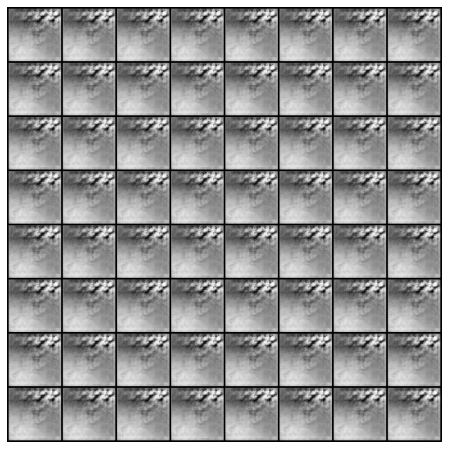

In [9]:
animate_gen_imgs()

# Trian : izif E

In [10]:
DC.eval()
D.eval()

kappa = 1.0
EC_losses = []

iters = 0
AE_img_list = []

def train_AE(epoch):
    global epochs
    global iters
    global EC_losses
    global AE_img_list
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        real_imgs = data[0].to(device)
        
        EC_optimizer.zero_grad()
        
        EC_validity = EC(real_imgs)
        
        fake_imgs = DC(EC_validity)
        
        _, real_features = D.forward(real_imgs)
        _, fake_features = D.forward(fake_imgs)
        
        
        # izif architecture
        imgs_loss = AE_criterion(real_imgs, fake_imgs)
        features_loss = AE_criterion(real_features, fake_features)
        EC_loss = imgs_loss + kappa*features_loss
        
        EC_loss.backward()
        EC_optimizer.step()
        
        # =============================================================
        # print
        # =============================================================
        print('[%d/%d][%d/%d]\n- E_loss: %.4f\n'
              %(epoch+1, epochs, i, len(data_loader), EC_loss.item()))
        
        # Save Losses for plotting later
        EC_losses.append(EC_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(EC_validity).detach().cpu()
            AE_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [ ]:
for epoch in range(epochs):
    train_AE(epoch)

[1/100][0/15]
- E_loss: 0.2040

[1/100][1/15]
- E_loss: 0.2130

[1/100][2/15]
- E_loss: 0.1966

[1/100][3/15]
- E_loss: 0.1869

[1/100][4/15]
- E_loss: 0.1794

[1/100][5/15]
- E_loss: 0.1825

[1/100][6/15]
- E_loss: 0.1705

[1/100][7/15]
- E_loss: 0.1948

[1/100][8/15]
- E_loss: 0.1611

[1/100][9/15]
- E_loss: 0.1763

[1/100][10/15]
- E_loss: 0.2310

[1/100][11/15]
- E_loss: 0.2046

[1/100][12/15]
- E_loss: 0.1707

[1/100][13/15]
- E_loss: 0.2293

[1/100][14/15]
- E_loss: 0.1697

[2/100][0/15]
- E_loss: 0.2211

[2/100][1/15]
- E_loss: 0.1986

[2/100][2/15]
- E_loss: 0.1850

[2/100][3/15]
- E_loss: 0.1985

[2/100][4/15]
- E_loss: 0.1960

[2/100][5/15]
- E_loss: 0.2180

[2/100][6/15]
- E_loss: 0.1915

[2/100][7/15]
- E_loss: 0.1889

[2/100][8/15]
- E_loss: 0.1550

[2/100][9/15]
- E_loss: 0.1813

[2/100][10/15]
- E_loss: 0.1948

[2/100][11/15]
- E_loss: 0.1737

[2/100][12/15]
- E_loss: 0.1795

[2/100][13/15]
- E_loss: 0.2131

[2/100][14/15]
- E_loss: 0.2081

[3/100][0/15]
- E_loss: 0.1830

[17/100][12/15]
- E_loss: 0.1581

[17/100][13/15]
- E_loss: 0.2145

[17/100][14/15]
- E_loss: 0.1943

[18/100][0/15]
- E_loss: 0.2085

[18/100][1/15]
- E_loss: 0.2078

[18/100][2/15]
- E_loss: 0.2183

[18/100][3/15]
- E_loss: 0.1665

[18/100][4/15]
- E_loss: 0.1656

[18/100][5/15]
- E_loss: 0.1836

[18/100][6/15]
- E_loss: 0.1930

[18/100][7/15]
- E_loss: 0.1998

[18/100][8/15]
- E_loss: 0.2175

[18/100][9/15]
- E_loss: 0.1782

[18/100][10/15]
- E_loss: 0.1706

[18/100][11/15]
- E_loss: 0.1784

[18/100][12/15]
- E_loss: 0.1813

[18/100][13/15]
- E_loss: 0.2205

[18/100][14/15]
- E_loss: 0.1985

[19/100][0/15]
- E_loss: 0.1854

[19/100][1/15]
- E_loss: 0.1839

[19/100][2/15]
- E_loss: 0.1850

[19/100][3/15]
- E_loss: 0.1725

[19/100][4/15]
- E_loss: 0.2399

[19/100][5/15]
- E_loss: 0.1992

[19/100][6/15]
- E_loss: 0.1817

[19/100][7/15]
- E_loss: 0.2062

[19/100][8/15]
- E_loss: 0.2042

[19/100][9/15]
- E_loss: 0.1808

[19/100][10/15]
- E_loss: 0.1966

[19/100][11/15]
- E_loss: 0.1979



[34/100][3/15]
- E_loss: 0.1629

[34/100][4/15]
- E_loss: 0.1707

[34/100][5/15]
- E_loss: 0.1727

[34/100][6/15]
- E_loss: 0.1898

[34/100][7/15]
- E_loss: 0.2105

[34/100][8/15]
- E_loss: 0.1986

[34/100][9/15]
- E_loss: 0.2230

[34/100][10/15]
- E_loss: 0.2158

[34/100][11/15]
- E_loss: 0.1962

[34/100][12/15]
- E_loss: 0.2036

[34/100][13/15]
- E_loss: 0.1818

[34/100][14/15]
- E_loss: 0.1627

[35/100][0/15]
- E_loss: 0.1929

[35/100][1/15]
- E_loss: 0.1934

[35/100][2/15]
- E_loss: 0.2099

[35/100][3/15]
- E_loss: 0.1804

[35/100][4/15]
- E_loss: 0.1678

[35/100][5/15]
- E_loss: 0.1872

[35/100][6/15]
- E_loss: 0.1517

[35/100][7/15]
- E_loss: 0.2179

[35/100][8/15]
- E_loss: 0.2099

[35/100][9/15]
- E_loss: 0.2281

[35/100][10/15]
- E_loss: 0.1890

[35/100][11/15]
- E_loss: 0.1876

[35/100][12/15]
- E_loss: 0.1940

[35/100][13/15]
- E_loss: 0.1964

[35/100][14/15]
- E_loss: 0.1952

[36/100][0/15]
- E_loss: 0.2185

[36/100][1/15]
- E_loss: 0.1961

[36/100][2/15]
- E_loss: 0.2026



[50/100][9/15]
- E_loss: 0.2127

[50/100][10/15]
- E_loss: 0.2356

[50/100][11/15]
- E_loss: 0.2096

[50/100][12/15]
- E_loss: 0.1972

[50/100][13/15]
- E_loss: 0.1957

[50/100][14/15]
- E_loss: 0.1806

[51/100][0/15]
- E_loss: 0.1861

[51/100][1/15]
- E_loss: 0.1785

[51/100][2/15]
- E_loss: 0.2048

[51/100][3/15]
- E_loss: 0.2205

[51/100][4/15]
- E_loss: 0.1517

[51/100][5/15]
- E_loss: 0.1934

[51/100][6/15]
- E_loss: 0.2048

[51/100][7/15]
- E_loss: 0.2059

[51/100][8/15]
- E_loss: 0.1929

[51/100][9/15]
- E_loss: 0.1772

[51/100][10/15]
- E_loss: 0.1970

[51/100][11/15]
- E_loss: 0.2011

[51/100][12/15]
- E_loss: 0.1659

[51/100][13/15]
- E_loss: 0.2126

[51/100][14/15]
- E_loss: 0.2044

[52/100][0/15]
- E_loss: 0.2137

[52/100][1/15]
- E_loss: 0.2126

[52/100][2/15]
- E_loss: 0.1743

[52/100][3/15]
- E_loss: 0.1708

[52/100][4/15]
- E_loss: 0.2168

[52/100][5/15]
- E_loss: 0.1981

[52/100][6/15]
- E_loss: 0.2028

[52/100][7/15]
- E_loss: 0.1538

[52/100][8/15]
- E_loss: 0.1542



[67/100][0/15]
- E_loss: 0.2205

[67/100][1/15]
- E_loss: 0.2022

[67/100][2/15]
- E_loss: 0.1868

[67/100][3/15]
- E_loss: 0.2012

[67/100][4/15]
- E_loss: 0.1655

[67/100][5/15]
- E_loss: 0.2014

[67/100][6/15]
- E_loss: 0.2022

[67/100][7/15]
- E_loss: 0.2077

[67/100][8/15]
- E_loss: 0.1793

[67/100][9/15]
- E_loss: 0.1961

[67/100][10/15]
- E_loss: 0.1836

[67/100][11/15]
- E_loss: 0.1605

[67/100][12/15]
- E_loss: 0.2018

[67/100][13/15]
- E_loss: 0.1926

[67/100][14/15]
- E_loss: 0.2142

[68/100][0/15]
- E_loss: 0.2136

[68/100][1/15]
- E_loss: 0.2132

[68/100][2/15]
- E_loss: 0.2044

[68/100][3/15]
- E_loss: 0.1912

[68/100][4/15]
- E_loss: 0.1576

[68/100][5/15]
- E_loss: 0.1980

[68/100][6/15]
- E_loss: 0.1682

[68/100][7/15]
- E_loss: 0.2033

[68/100][8/15]
- E_loss: 0.1904

[68/100][9/15]
- E_loss: 0.1645

[68/100][10/15]
- E_loss: 0.1989

[68/100][11/15]
- E_loss: 0.2409

[68/100][12/15]
- E_loss: 0.1845

[68/100][13/15]
- E_loss: 0.1725

[68/100][14/15]
- E_loss: 0.1906



# Loss Graph

In [ ]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(DC_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.plot(EC_losses, label="E")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
plot_train_loss()

---

# Test Data

In [ ]:
#test_data_root = "../../dataset/test/test_DualPhaseSteel"
Ti64_test_data_root = "../../dataset/test/test_Ti64"

test_data_set = dataset.ImageFolder(root = Ti64_test_data_root, # test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# 이상 픽셀 수 확인 함수

In [ ]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# img 비교 함수

In [ ]:
def compare_imgs(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    
    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

# Test

In [ ]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

ano_criterion = nn.MSELoss()
DC.eval()
D.eval()
EC.eval()

# with open("score.csv", "w") as f:
#         f.write("label,img_distance,anomaly_score,z_distance\n")

for i, data in enumerate(test_data_loader, 0):
    real_img = data[0].to(device)

    real_z = EC(real_img) # 진짜 이미지의 latent vector
    fake_img = DC(real_z) # DC에 넣어서 가짜 이미지 생성.
    fake_z = EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    _, real_feature = D.forward(real_img) # 1, 256
    _, fake_feature = D.forward(fake_img)

    img_distance = ano_criterion(fake_img, real_img)
    loss_feature = ano_criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = ano_criterion(fake_z, real_z)
    
#     with open("score.csv", "a") as f:
#             f.write(f"{label.item()},{img_distance},"
#                     f"{anomaly_score},{z_distance}\n")
            
#     print(f"{label.item()}, {img_distance}, "
#           f"{anomaly_score}, {z_distance}\n")
    compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

---

# 분율 추출

In [ ]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

In [ ]:
sum(diff_fraction)/len(diff_fraction)

---

# 분산 추출

In [ ]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [ ]:
cal_corr_coeffis()

print(corr_coeffis)

---

# 모델 저장 및 읽기

In [ ]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "DC" : DC.state_dict(),
        "EC" : EC.state_dict()
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [ ]:
save_pretrained()

In [ ]:
pretrained_D = Discriminator().to(device)
pretrained_DC = Decoder().to(device)
pretrained_EC = Encoder().to(device)

def load_pretrained():
    global pretrained_D
    global pretrained_DC
    global pretrained_EC
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_DC.load_state_dict(pretrained["DC"])
    pretrained_EC.load_state_dict(pretrained["EC"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_DC)
    #print("pretrained_E :", pretrained_EC)

In [ ]:
load_pretrained()

In [ ]:
def test():
    ano_criterion = nn.MSELoss()
    pretrained_DC.eval()
    pretrained_D.eval()
    pretrained_EC.eval()

    # with open("score.csv", "w") as f:
    #         f.write("label,img_distance,anomaly_score,z_distance\n")

    for i, data in enumerate(test_data_loader, 0):
        real_img = data[0].to(device)

        real_z = pretrained_EC(real_img) # 진짜 이미지의 latent vector
        fake_img = pretrained_DC(real_z) # DC에 넣어서 가짜 이미지 생성.
        fake_z = pretrained_EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

        _, real_feature = pretrained_D.forward(real_img) # 1, 256
        _, fake_feature = pretrained_D.forward(fake_img)

        img_distance = ano_criterion(fake_img, real_img)
        loss_feature = ano_criterion(fake_feature, real_feature)

        anomaly_score = img_distance + kappa*loss_feature

        z_distance = ano_criterion(fake_z, real_z)

    #     with open("score.csv", "a") as f:
    #             f.write(f"{label.item()},{img_distance},"
    #                     f"{anomaly_score},{z_distance}\n")

    #     print(f"{label.item()}, {img_distance}, "
    #           f"{anomaly_score}, {z_distance}\n")
        compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

In [ ]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [ ]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

In [ ]:
cal_corr_coeffis()

print(corr_coeffis)

---

# anomaly detection 이미지 추출

In [ ]:
anomaly_imgs

# 이미지 저장 함수

In [ ]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [ ]:
save_imgs("./anomaly_imgs", anomaly_imgs)

---

# 티타늄(Ti64) 상대 밀도 계산

In [ ]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)